In [1]:

import pandas as pd
from sklearn.model_selection import train_test_split
import csv

file_path = "C:/project/news_cleaned_2018_02_13.csv"
csv.field_size_limit(100000000)

# Read the dataset in chunks and sample 9000 rows total
sample_chunks = []
total_rows_needed = 9000
rows_collected = 0

for chunk in pd.read_csv(file_path, chunksize=100000, on_bad_lines='warn', engine='python'):
    remaining_rows = total_rows_needed - rows_collected
    if remaining_rows <= 0:
        break
    sample_size = int(min(remaining_rows, len(chunk)))
    sample = chunk.sample(n=sample_size, random_state=42)
    sample_chunks.append(sample)
    rows_collected += len(sample)

df = pd.concat(sample_chunks, ignore_index=True)

# Split into train (5000), test (2000), and validation (2000)
train_df, temp_df = train_test_split(df, train_size=5000, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Save to CSV
train_df.to_csv("C:/kushal_nlp_project/train_data.csv", index=False)
val_df.to_csv("C:/kushal_nlp_project/val_data.csv", index=False)
test_df.to_csv("C:/kushal_nlp_project/test_data.csv", index=False)



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\PratikSapkota\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\PratikSapkota\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\PratikSapkota\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PratikSapkota\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\PratikSapkota\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


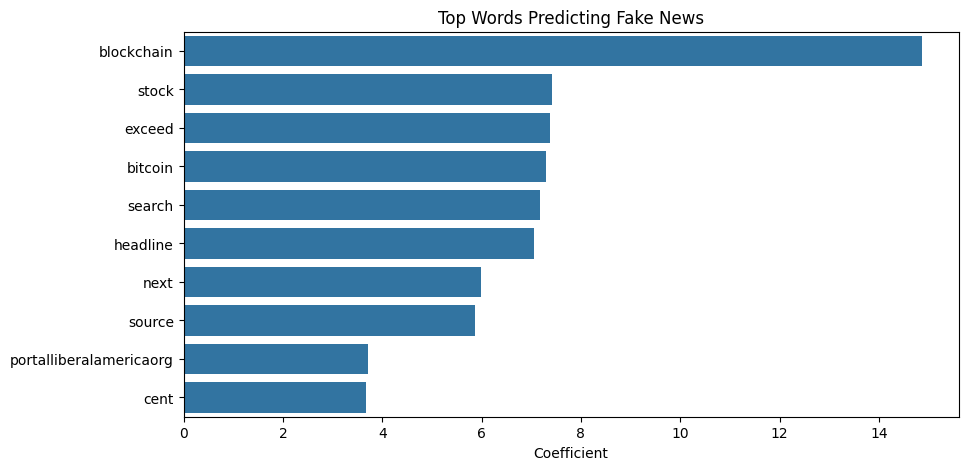

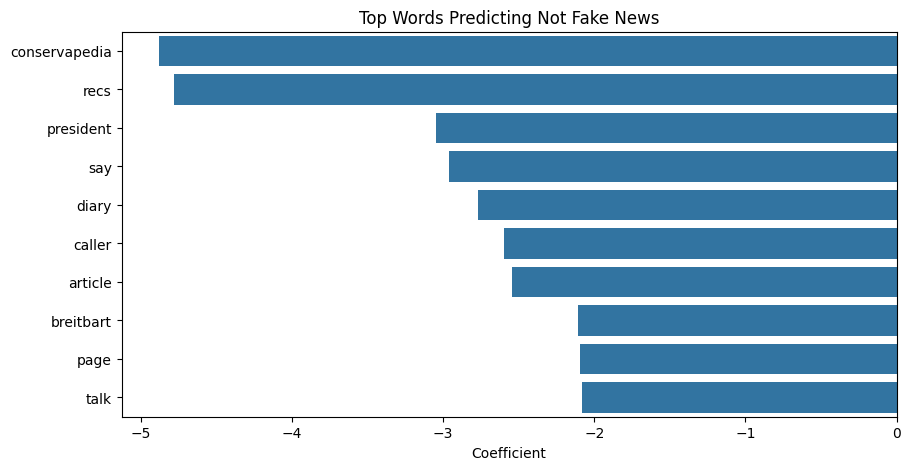

C:\Users\PratikSapkota\AppData\Local\Temp\ipykernel_14824\3569265226.py:105: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=pd.concat([train_df, val_df, test_df]), palette='Set2')


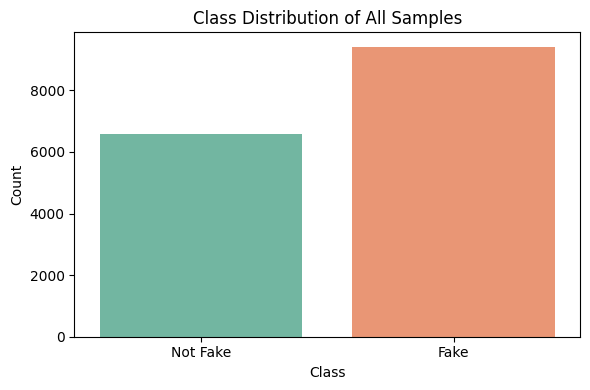

C:\Users\PratikSapkota\AppData\Local\Temp\ipykernel_14824\3569265226.py:120: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(freqs), y=list(words), palette='viridis')


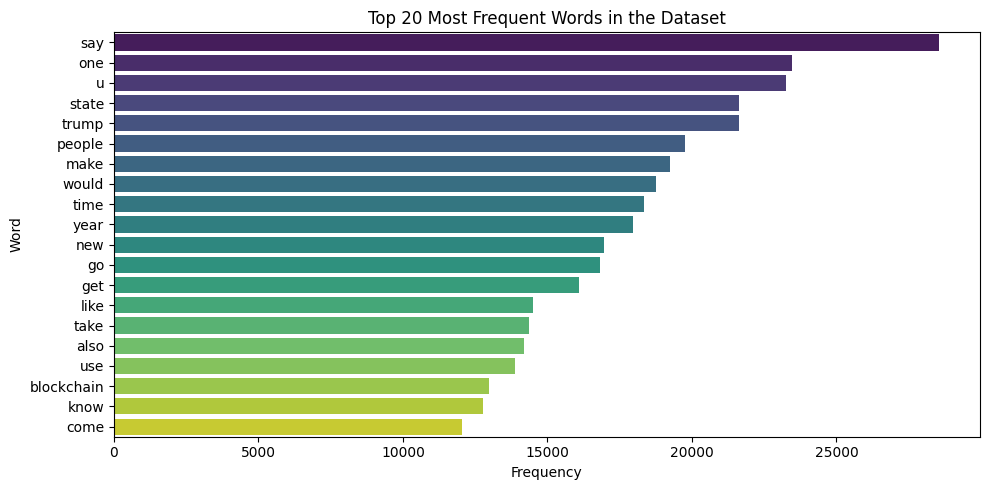

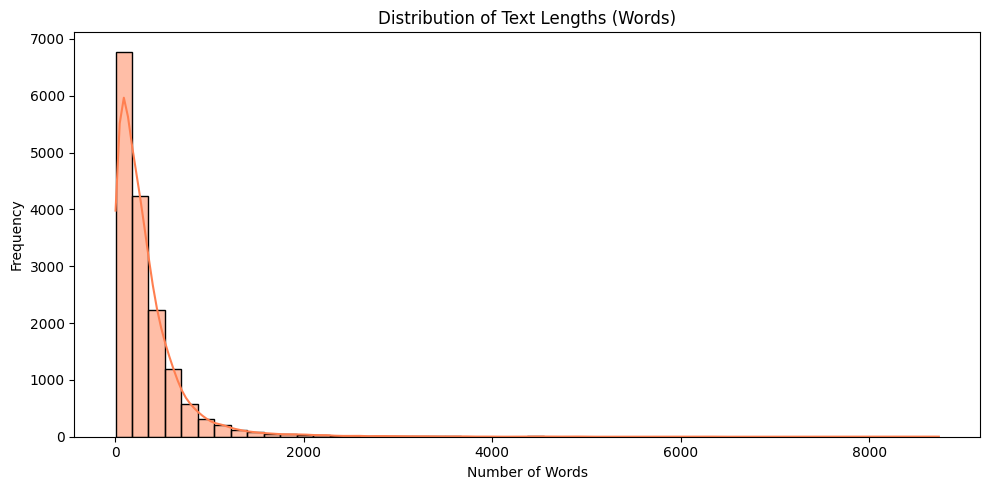


✅ Final Evaluation
Validation Accuracy: 0.8856666666666667
Test Accuracy: 0.9023333333333333

Validation Report:
               precision    recall  f1-score   support

    Not Fake       0.83      0.92      0.87      1293
        Fake       0.93      0.86      0.90      1707

    accuracy                           0.89      3000
   macro avg       0.88      0.89      0.88      3000
weighted avg       0.89      0.89      0.89      3000

Test Report:
               precision    recall  f1-score   support

    Not Fake       0.84      0.94      0.89      1235
        Fake       0.95      0.88      0.91      1765

    accuracy                           0.90      3000
   macro avg       0.90      0.91      0.90      3000
weighted avg       0.91      0.90      0.90      3000



In [2]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# ─── NLTK SETUP ──────────────────────────────────────────────────────────
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('omw-1.4')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# ─── TEXT CLEANING + LEMMATIZATION ───────────────────────────────────────
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def lemmatize_text(text):
    text = str(text).lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t not in stop_words]
    tagged = pos_tag(tokens)
    lemmatized = [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in tagged]
    return ' '.join(lemmatized)

# ─── LOAD DATA ───────────────────────────────────────────────────────────
train_df = pd.read_csv("C:/kushal_nlp_project/new/train_data.csv")
val_df = pd.read_csv("C:/kushal_nlp_project/new/val_data.csv")
test_df = pd.read_csv("C:/kushal_nlp_project/new/test_data.csv")

# ─── LABEL CREATION ──────────────────────────────────────────────────────
fake_types = ['fake', 'clickbait', 'conspiracy', 'unreliable', 'rumor', 'junksci', 'hate', 'satire']
for df in [train_df, val_df, test_df]:
    df['label'] = df['type'].apply(lambda x: 1 if str(x).strip().lower() in fake_types else 0)
    df['text'] = df['title'].fillna('') + ' ' + df['content'].fillna('')
    df['clean_text'] = df['text'].apply(lemmatize_text)

# ─── TF-IDF VECTORIZATION ────────────────────────────────────────────────
vectorizer = TfidfVectorizer(min_df=2, max_df=0.8)
X_train = vectorizer.fit_transform(train_df['clean_text'])
X_val = vectorizer.transform(val_df['clean_text'])
X_test = vectorizer.transform(test_df['clean_text'])

y_train = train_df['label']
y_val = val_df['label']
y_test = test_df['label']

# ─── MODEL TRAINING ───────────────────────────────────────────────────────
model = LogisticRegression(class_weight='balanced', max_iter=1000)
model.fit(X_train, y_train)

# ─── PREDICTION AND EVALUATION ────────────────────────────────────────────
val_preds = model.predict(X_val)
test_preds = model.predict(X_test)

val_accuracy = accuracy_score(y_val, val_preds)
test_accuracy = accuracy_score(y_test, test_preds)
val_report = classification_report(y_val, val_preds, target_names=['Not Fake', 'Fake'])
test_report = classification_report(y_test, test_preds, target_names=['Not Fake', 'Fake'])

# ─── FEATURE IMPORTANCE PLOTS ─────────────────────────────────────────────
feature_names = np.array(vectorizer.get_feature_names_out())
coef = model.coef_[0]
top_fake_idx = np.argsort(coef)[-10:][::-1]
top_real_idx = np.argsort(coef)[:10]

plt.figure(figsize=(10, 5))
sns.barplot(x=coef[top_fake_idx], y=feature_names[top_fake_idx])
plt.title("Top Words Predicting Fake News")
plt.xlabel("Coefficient")
plt.show()

plt.figure(figsize=(10, 5))
sns.barplot(x=coef[top_real_idx], y=feature_names[top_real_idx])
plt.title("Top Words Predicting Not Fake News")
plt.xlabel("Coefficient")
plt.show()

# ─── ADDITIONAL PLOTS ─────────────────────────────────────────────────────

# 1. Class Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=pd.concat([train_df, val_df, test_df]), palette='Set2')
plt.xticks([0, 1], ['Not Fake', 'Fake'])
plt.title("Class Distribution of All Samples")
plt.xlabel("Class")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# 2. Top 20 Frequent Words
all_tokens = ' '.join(pd.concat([train_df, val_df, test_df])['clean_text']).split()
word_freq = Counter(all_tokens)
top_words = word_freq.most_common(20)
words, freqs = zip(*top_words)

plt.figure(figsize=(10, 5))
sns.barplot(x=list(freqs), y=list(words), palette='viridis')
plt.title("Top 20 Most Frequent Words in the Dataset")
plt.xlabel("Frequency")
plt.ylabel("Word")
plt.tight_layout()
plt.show()

# 3. Text Length Distribution
df_all = pd.concat([train_df, val_df, test_df])
df_all['text_len'] = df_all['clean_text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 5))
sns.histplot(df_all['text_len'], bins=50, kde=True, color='coral')
plt.title("Distribution of Text Lengths (Words)")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# ─── FINAL REPORT ─────────────────────────────────────────────────────────
print("\n✅ Final Evaluation")
print("Validation Accuracy:", val_accuracy)
print("Test Accuracy:", test_accuracy)
print("\nValidation Report:\n", val_report)
print("Test Report:\n", test_report)


In [3]:
# Assume `model` and `vectorizer` are already trained on the original dataset

# Preprocess LIAR dataset (same lemmatization function used previously)
liar_headers = [
    "id", "label", "statement", "subject", "speaker", "job_title", "state_info", "party_affiliation",
    "barely_true_counts", "false_counts", "half_true_counts", "mostly_true_counts", "pants_onfire_counts", "context"
]

# Load LIAR dataset
train_df_liar = pd.read_csv("C:/project/liar_dataset/train.tsv", sep="\t", header=None, names=liar_headers)
val_df_liar   = pd.read_csv("C:/project/liar_dataset/valid.tsv", sep="\t", header=None, names=liar_headers)
test_df_liar  = pd.read_csv("C:/project/liar_dataset/test.tsv",  sep="\t", header=None, names=liar_headers)

# Map label to binary (1 = Fake, 0 = Not Fake)
fake_labels = ['false', 'pants-fire', 'barely-true']
true_labels = ['true', 'mostly-true', 'half-true']
map_label = lambda x: 1 if str(x).lower() in fake_labels else 0

for df in [train_df_liar, val_df_liar, test_df_liar]:
    df['label'] = df['label'].apply(map_label)
    df['text'] = df['statement'].fillna('') + ' ' + df['context'].fillna('')
    df['clean_text'] = df['text'].apply(lemmatize_text)

# Transform using previously fitted vectorizer
X_val_liar = vectorizer.transform(val_df_liar['clean_text'])
X_test_liar = vectorizer.transform(test_df_liar['clean_text'])
y_val_liar = val_df_liar['label']
y_test_liar = test_df_liar['label']

# Predict using existing model
val_preds_liar = model.predict(X_val_liar)
test_preds_liar = model.predict(X_test_liar)

# Evaluate
from sklearn.metrics import accuracy_score, classification_report

print("Validation Accuracy on LIAR:", accuracy_score(y_val_liar, val_preds_liar))
print("Test Accuracy on LIAR:", accuracy_score(y_test_liar, test_preds_liar))

print("\nValidation Report:\n", classification_report(y_val_liar, val_preds_liar, target_names=['Not Fake', 'Fake']))
print("Test Report:\n", classification_report(y_test_liar, test_preds_liar, target_names=['Not Fake', 'Fake']))


Validation Accuracy on LIAR: 0.514018691588785
Test Accuracy on LIAR: 0.5556432517758485

Validation Report:
               precision    recall  f1-score   support

    Not Fake       0.52      0.93      0.67       668
        Fake       0.45      0.06      0.11       616

    accuracy                           0.51      1284
   macro avg       0.48      0.50      0.39      1284
weighted avg       0.49      0.51      0.40      1284

Test Report:
               precision    recall  f1-score   support

    Not Fake       0.56      0.93      0.70       714
        Fake       0.44      0.07      0.12       553

    accuracy                           0.56      1267
   macro avg       0.50      0.50      0.41      1267
weighted avg       0.51      0.56      0.45      1267

